In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import njit
from scipy.ndimage import convolve, generate_binary_structure
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

# Ising Model 2D 

## Metropolis Algorithm

1. Escoger aleatoriamente un estado $\mu$.
2. Escoger aleatoriamente una partícula en el lattice e invertir la dirección del spín. Este será el estado $\nu$. Ahora, buscar la probabilidad $P(\mu \rightarrow \nu)$ para aceptar este nuevo estado.
3. Si $E_{\nu} > E_{\mu}$, entonces $P(\nu \rightarrow \mu)= 1$ y, por tanto, se acepta el estado con una probabilidad $P(\mu \rightarrow \nu)=  e^{-\beta(E_{\nu} - E_{\mu})}$. De lo contrario, si $E_{\nu} < E_{\mu}$,  entonces $P(\mu \rightarrow \nu)= 1$ y, por tanto, se acepta el nuevo estado.
4. Repetir hasta alcanzar un estado de equilibrio.

*Notese que el cambio de energía en cada nuevo estado puede ser calculado únicamente teniendo en cuenta al spín seleccionado y sus vecinos. Esto es, $-\beta(E_{\nu} - E_{\mu}) = -\beta J \sum_{k=1}^{4} \sigma_i \sigma_k$

In [2]:
#Cuadrícula 50x50
N= 50

In [3]:
#Lattice negativo
init_random = np.random.random((N,N))
lattice_n = np.zeros((N, N))
lattice_n[init_random>=0.75] = 1
lattice_n[init_random<0.75] = -1

#Lattice positivo
init_random = np.random.random((N,N))
lattice_p = np.zeros((N, N))
lattice_p[init_random>=0.25] = 1
lattice_p[init_random<0.25] = -1

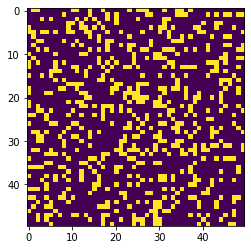

In [4]:
plt.imshow(lattice_n)

La energía del sistema en un estado $\mu$ está dada por 
$$E_{\mu}= \sum_{<i,j>} -J \sigma_i \sigma_j$$

In [6]:
def get_energy(lattice):
    # Suma sobre los vecinos adyacentes
    kern = generate_binary_structure(2, 1) 
    kern[1][1] = False
    arr = -lattice * convolve(lattice, kern, mode='constant', cval=0)
    return arr.sum()

In [36]:
@numba.njit("UniTuple(f8[:], 2)(f8[:,:], i8, f8, f8)", nopython=True, nogil=True)
def metropolis_algorithm(spin_arr, times, BJ, energy):
    spin_arr = spin_arr.copy()
    net_spins = np.zeros(times-1)
    net_energy = np.zeros(times-1)
    for t in range(0,times-1):
        # 2. Seleccionar un punto al azar y voltear el spin
        
        x = np.random.randint(0,N)
        y = np.random.randint(0,N)
        spin_i = spin_arr[x,y] 
        spin_f = spin_i*-1 #Cambio de espin 
        
        # Calcular el cambio de energía
        
        
        E_i = 0
        E_f = 0
        
        #Usando condiciones de frontera periódicas 
        
        left_x = (x - 1) % N  
        right_x = (x + 1) % N
        up_y = (y - 1) % N  
        down_y = (y + 1) % N
        
        E_i += -spin_i * (spin_arr[left_x, y] + spin_arr[right_x, y] + spin_arr[x, up_y] + spin_arr[x, down_y])
        E_f += -spin_f * (spin_arr[left_x, y] + spin_arr[right_x, y] + spin_arr[x, up_y] + spin_arr[x, down_y])
        
        # 3 / 4. Cambiar los estados de acuerdo a las probabilidades
        
        dE = E_f-E_i
        if (dE>0)*(np.random.random() < np.exp(-BJ*dE)):
            spin_arr[x,y]=spin_f
            energy += dE
        elif dE<=0:
            spin_arr[x,y]=spin_f
            energy += dE
            
        net_spins[t] = spin_arr.sum()
        net_energy[t] = energy
            
    return net_spins, net_energy

/opt/anaconda3/lib/python3.7/site-packages/numba/decorators.py:220: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


Para estudiar la convergencia de la energía, escogamos un $\beta J$ arbitrario.

In [47]:
#Haremos 1000000 iteraciones
spins, energies = metropolis_algorithm(lattice_n, 1000000, 1.0, get_energy(lattice_n))

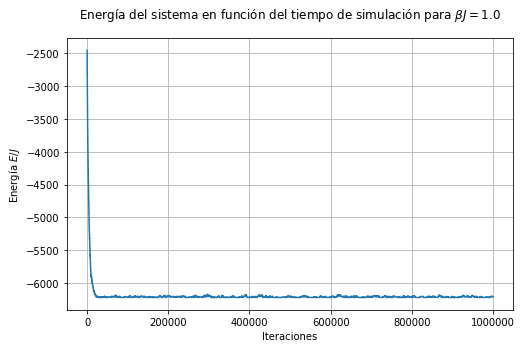

In [48]:
fig, ax = plt.subplots(figsize=(8, 5))

# Grafica de la energía
ax.plot(energies)
ax.set_xlabel('Iteraciones')
ax.set_ylabel(r'Energía $E/J$')
ax.grid()

# Set the title
ax.set_title(r'Energía del sistema en función del tiempo de simulación para $\beta J=$1.0', size=12, y=1.05)

plt.show()

In [45]:
#Haremos 1000000 iteraciones
spins, energies = metropolis_algorithm(lattice_n, 1000000, 0.5, get_energy(lattice_n))

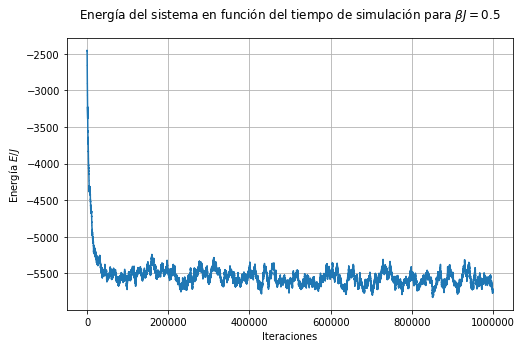

In [46]:
fig, ax = plt.subplots(figsize=(8, 5))

# Grafica de la energía
ax.plot(energies)
ax.set_xlabel('Iteraciones')
ax.set_ylabel(r'Energía $E/J$')
ax.grid()

# Set the title
ax.set_title(r'Energía del sistema en función del tiempo de simulación para $\beta J=$0.5', size=12, y=1.05)

plt.show()

In [37]:
def magnetization(lattice, BJs):
    magn_ = np.zeros(len(BJs))
    for i, bj in enumerate(BJs):
        spins, energies = metropolis_algorithm(lattice, 1000000, bj, get_energy(lattice))
        magn_[i] = spins[-100000:].mean()/N**2
    return magn_

#Diferentes valores de temperatura    
BJs = np.arange(0.1, 2, 0.05)
magn_n = magnetization(lattice_n, BJs)
magn_p = magnetization(lattice_p, BJs)

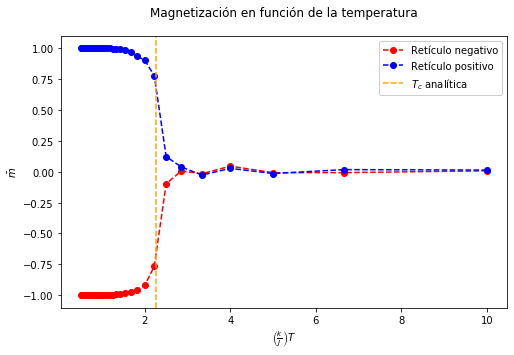

In [43]:
plt.figure(figsize=(8,5))
plt.plot(1/BJs, magn_n, 'o--', label='Retículo negativo', c= "red")
plt.plot(1/BJs, magn_p, 'o--', label='Retículo positivo', c= "blue")
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$\bar{m}$')
plt.axvline(x=2.26, color='orange', linestyle='--', label=r'$T_c$ analítica')
plt.legend(facecolor='white', framealpha=1)
plt.title("Magnetización en función de la temperatura", size= 12, y=1.05 )
plt.show()